## Import

In [478]:
import pandas as pd
import folium
import time
import re
import numpy as np

#spark session
from pyspark.sql import SparkSession


#feature engineering
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


#xgboost evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor




In [479]:
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [480]:
# read files
data = pd.read_csv('../data/curated/model-data/model-data.csv')
data = data.drop(columns = ['latitude', 'longitude'])

In [481]:
data = data.loc[(data['price'] <= 1500) & (data['bedrooms'] <= 3)& (data['parking'] <= 5)]
data = data.loc[(data['price'] <= 2000) & (data['bedrooms'] <= 5)& (data['parking'] <= 5)]

In [482]:
data = spark.createDataFrame(data)

#split future data for test set
TEST_SIZE = 0.2
train, test= data.randomSplit([1-TEST_SIZE, TEST_SIZE])



In [483]:
# string indexer 
string_indexer_columns = ['property_type']

# string indexer 
string_indexer_columns = ['property_type']
StringIndexer = [StringIndexer(inputCol= column, outputCol='{0}_index'.format(column)).setHandleInvalid("keep")\
                  for column in string_indexer_columns] 

In [484]:
# one hot encoder, put unseen value in new bucket
onehot_columns = ['postcode',
                  'bedrooms','bathrooms','parking',
                  'property_type_index']
OneHotEncoders = [OneHotEncoder(inputCol= column, outputCol='{0}_vec'.format(column)).setHandleInvalid("keep")\
                  for column in onehot_columns] 

In [485]:
# other columns
other_columns = ['price',
                 'postcode_property_count','property-count', 'elector-count',
                 'public-service-duration','care-facility-duration', 'shopping-center-duration',
                 'train-station-duration', 'hospital-duration', 'CBD-duration',
                 'emergency-service-duration', 'crime-rate', 'income',
                 'pri-1-10', 'pri-11-50', 'pri-51-100','pri-101-150', 'pri-150+',
                 'sec-1-10', 'sec-11-50', 'sec-51-100','sec-101-150', 'sec-150+']

# create feature vector
featuresCreator = VectorAssembler(
    inputCols=[OneHotEncoder.getOutputCol() for OneHotEncoder in OneHotEncoders] + other_columns,
    outputCol='features')

In [486]:
#pipeline before fit clasifyer
pipeline_model = (Pipeline(stages = StringIndexer + OneHotEncoders + [featuresCreator])).fit(train)

In [487]:
#create feature columns as MLP input
train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

In [488]:
#feature scaling
Scalerizer=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
train_scaled = Scalerizer.fit(train).transform(train)
test_scaled = Scalerizer.fit(test).transform(test)

## Gradient boost tree regression

In [505]:

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# define classifier
classifier = GBTRegressor(featuresCol="Scaled_features", labelCol="price", maxIter=10)

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [ 5, 10, 15, 20, 30, 50])
             .addGrid(classifier.maxBins, [5, 10, 20, 30, 40, 50])
             .addGrid(classifier.maxIter, [5, 10, 20, 30, 40, 50])
             .build())

#train validation split
tvs = TrainValidationSplit( estimator= classifier
                           ,estimatorParamMaps= paramGrid
                           ,evaluator= MulticlassClassificationEvaluator(labelCol='price')
                           ,trainRatio=0.8)
#fit model
GBTmodel = classifier.fit(train_scaled)

#get output
GBTtrain_output_df = GBTmodel.transform(train_scaled)
GBTtest_output_df = GBTmodel.transform(test_scaled)


In [490]:
#get predictions
GBTtrain_predictionAndPrices = GBTtrain_output_df.select('prediction', 'price')
GBTtest_predictionAndPrices = GBTtest_output_df.select('prediction', 'price')

In [491]:
df_test = GBTtest_output_df.groupby('postcode').avg().toPandas()
columns = ['postcode','avg(prediction)','avg(price)']
df_test[columns].to_csv('test_data_output.csv')

In [492]:
from pyspark.mllib.evaluation import RegressionMetrics
# It needs to convert to RDD as the parameter of RegressionMetrics
GBTtest_predictionAndPrices_rdd = GBTtest_predictionAndPrices.rdd.map(tuple)


metrics = RegressionMetrics(GBTtest_predictionAndPrices_rdd)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


MSE = 991.4435822698131
RMSE = 31.487197116761806
MAE = 15.109065969869627


## XGBoost model

In [513]:
columns_xgb = ['postcode',
 'bedrooms','bathrooms','parking',
 'price',
 'postcode_property_count',
 'public-service-duration',
 'care-facility-duration',
 'shopping-center-duration',
 'train-station-duration',
 'hospital-duration',
 'CBD-duration',
 'emergency-service-duration',
 'property-count',
 'elector-count',
 'crime-rate',
 'income',
 'pri-1-10',
 'pri-11-50',
 'pri-51-100',
 'pri-101-150',
 'pri-150+',
 'sec-1-10',
 'sec-11-50',
 'sec-51-100',
 'sec-101-150',
 'sec-150+',
 'population-growth-rate',
 'property_type_index']

In [514]:
train_xgb = train[columns_xgb]
test_xgb = test[columns_xgb]

In [515]:
# train
y_train = train_xgb.toPandas()['price']
x_train = train_xgb.toPandas().drop(columns = ['price'])

# test
y_test = test_xgb.toPandas()['price']
x_test = test_xgb.toPandas().drop(columns = ['price'])

In [516]:
# xtrain get dummy
x_train = pd.get_dummies(x_train, columns = ['bedrooms', 'bathrooms', 'parking','property_type_index'] ) 

# xtest get dummy
x_test = pd.get_dummies(x_test, columns = ['bedrooms', 'bathrooms', 'parking','property_type_index'] ) 

In [517]:
# Get missing columns in the training test
missing_cols = set(x_train.columns)-set(x_test.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    x_test[c] = 0
    
# Ensure the order of column in the test set is in the same order than in train set
x_test = x_test[x_train.columns]

## Grid search for the best parameters

In [530]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:squarederror'],
              'learning_rate': [0.02, 0.05],
              'max_depth': [4, 6, 10],
              'min_child_weight': [ 5, 7],
              'n_estimators': [500, 1000]}

model = XGBRegressor()
xgb_grid = GridSearchCV(estimator = model,
                        param_grid = parameters,
                        scoring='r2', 
                        verbose=1,
                        cv = 3)
xgb_grid.fit(x_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 6, 10],
                         'min_child_weight': [5, 7],
                         'n_estimators': [500, 1000], 'nthread': [4],
                         'objective': ['reg:squarederror']},
             scoring='r2', verbose=1)

In [539]:
xgb_grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

In [542]:
classifier = XGBRegressor(learning_rate=0.02,
                     max_bin=256,
                     max_cat_to_onehot=4,
                     max_delta_step=0,
                     max_depth=4, 
                     max_leaves=0, 
                     min_child_weight=5,
                     n_estimators=500, 
                     n_jobs=4,
                     nthread=4, 
                     num_parallel_tree=1)
classifier .fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, ...)

## RMSE and r2 score


In [543]:
predictions = classifier.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

RMSE: 92.402694
R_Squared Score : 0.827156


## Top 15 importance features based on F score
* with one-hot encoding on categorial columns: 'bedrooms', 'bathrooms', 'parking','property_type_index'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

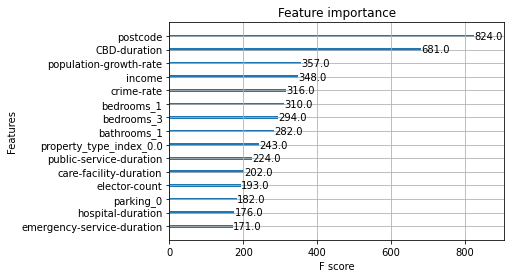

In [544]:
#  feature importance based on f score

plot_importance(classifier, max_num_features= 15)

## Top 15 importance features based on gain
* with one-hot encoding on categorial columns: 'bedrooms', 'bathrooms', 'parking','property_type_index'

,feature,importance
27,bathrooms_1,0.200934
26,bedrooms_3,0.097149
7,CBD-duration,0.093293
24,bedrooms_1,0.083156
12,income,0.058456
11,crime-rate,0.052726
18,sec-1-10,0.039592
25,bedrooms_2,0.033112
37,property_type_index_0.0,0.030724
33,parking_2,0.026616


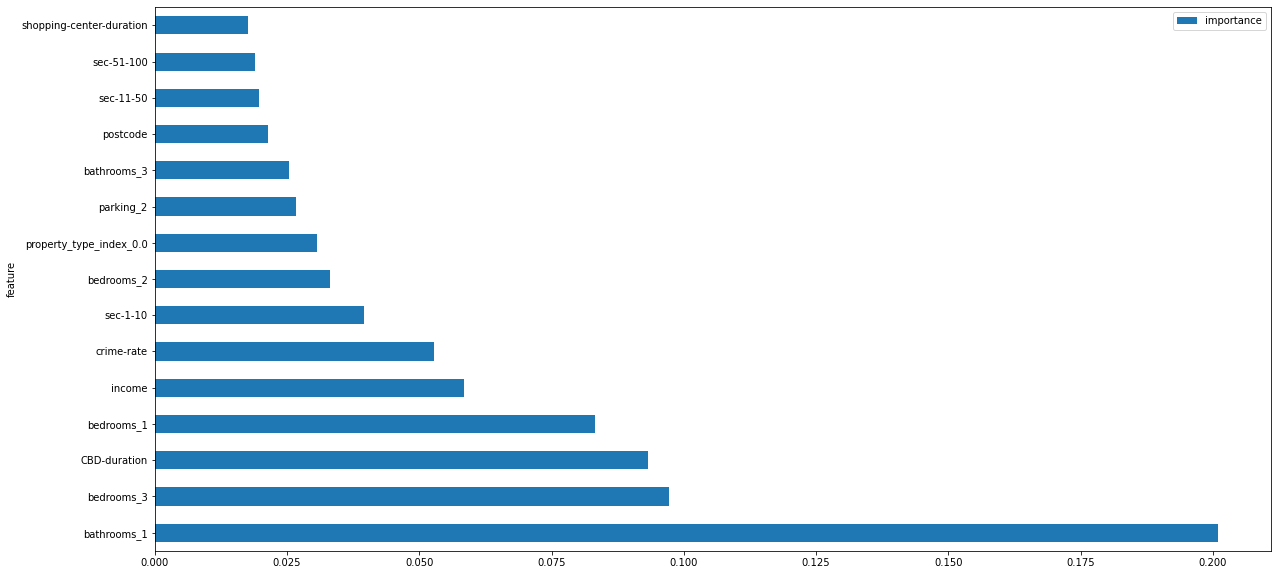

In [545]:
# create dict to use later
myfeatures = x_train.columns
dict_features = dict(enumerate(myfeatures))
list_imortance = list(classifier.feature_importances_)

# create dafaframe to store feature importance
features_df = pd.DataFrame.from_dict(dict_features, orient='index', columns = ['feature'])
features_df['importance'] = list_imortance
features_df = features_df.sort_values(by = ['importance'], ascending = False)

# ordered. by gain
features_df.head(15).plot(kind='barh', x='feature',figsize =(20,10))
features_df.head(15)